# t-SNE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X = pd.read_csv('checkpoints/mask_A_noise_ae/fold-0/latent_space.tsv',sep='\t', header=0, index_col=0)

In [3]:
labels = pd.read_csv('data/ABC_inter/Normalized/labels.tsv', sep='\t',header=0, index_col=0)

In [4]:
n_classes = 34 #no of classes to visualize
labels = labels[labels['sample_type.samples'].isin(range(n_classes))]

In [5]:
X = X.reset_index()
labels = labels.reset_index()

In [6]:
X = X.rename(columns={'index': 'sample'})

In [7]:
df = pd.merge(X, labels, on='sample', how='inner', sort=False)[['sample','sample_type.samples']]

In [8]:
X = X[X['sample'].isin(df['sample'])]

In [9]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df.loc[:,'sample_type.samples'], s=0.5)

NameError: name 'X_embedded' is not defined

In [9]:
import math

import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv


def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

In [10]:
import matplotlib
cm = generate_colormap(n_classes)
colors = []
for i in range(n_classes):
    rgba = cm(i)
    # rgb2hex accepts rgb or rgba
    colors.append(matplotlib.colors.rgb2hex(rgba))


In [11]:
tumors = ['LUAD','BRCA', 'UCEC','OV','LUSC','HNSC','KIRC','CESC','normal','PRAD','GBM','PAAD','BLCA','SARC',
 'THCA','KIRP','UVM','LIHC','SKCM','ACC','LGG','STAD','PCPG','TGCT','COAD','THYM','LAML','KICH','ESCA','UCS',
 'READ','MESO','DLBC','CHOL']

In [43]:
from tsnecuda import TSNE
X_embedded = TSNE(n_components=2, perplexity=5, learning_rate=30).fit_transform(X.iloc[:,1:])

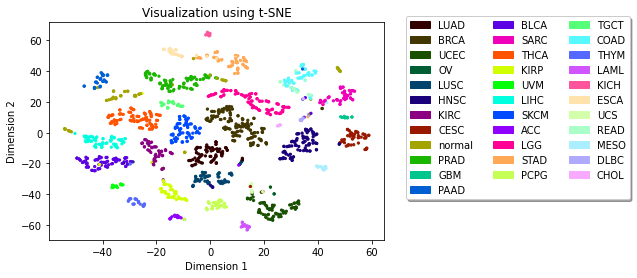

In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

x = X_embedded[:, 0]
y = X_embedded[:, 1]

categories = df.loc[:,'sample_type.samples'].to_numpy()

colormap = np.array(colors)

plt.scatter(x, y, s=5, c=colormap[categories])

pop_a = mpatches.Patch(color='#0b559f', label='Population A')
pop_b = mpatches.Patch(color='#89bedc', label='Population B')

handles = []
for t, c in zip(tumors, colors):
    handles.append(mpatches.Patch(color=c, label=t))

plt.legend(loc='upper center', bbox_to_anchor=(1.4, 1.05), handles=handles,
          ncol=3, fancybox=True, shadow=True)

plt.title('Visualization using t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig('images/tsne.png')
plt.show()

# Log

## Train log

In [25]:
path = "./checkpoints/omics_mode/ABC/ABC_inter/train_log.txt"
with open(path) as f:
    lines = f.readlines()

In [26]:
l = lines[-2]
sp = l.split(']')[1].split(': ')
int(sp[2].strip().split('  ')[0])

7166

In [27]:
def process_train_log(lines):
    recon_A, recon_B, recon_C, kl, classifier, accuracy = [], [], [], [], [], []
    for l in lines:
        if l.startswith("[TRAIN]"):
            # print(l)
            sp = l.split(']')[2].split(': ')
            spl = l.split(']')[1].split(': ')
            epoch = int(spl[2].strip().split('  ')[0])
            if(epoch==7166):
                recon_A.append(float(sp[1].split('  ')[0]))
                recon_B.append(float(sp[2].split('  ')[0]))
                recon_C.append(float(sp[3].split('  ')[0]))
                kl.append(float(sp[4].split('  ')[0]))
                classifier.append(float(sp[5].split('  ')[0]))
                accuracy.append(float(sp[6].split('  ')[0]))
                # print(recon_A, recon_B, recon_C, kl, classifier, accuracy)
    return recon_A, recon_B, recon_C, kl, classifier, accuracy

In [28]:
recon_A, recon_B, recon_C, kl, classifier, accuracy = process_train_log(lines)

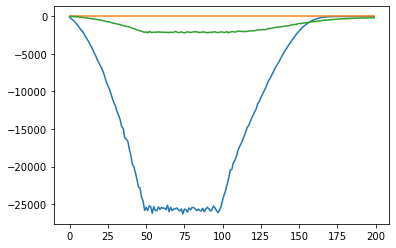

In [29]:
plt.plot(recon_A)
plt.plot(recon_B)
plt.plot(recon_C)

Text(0.5, 1.0, 'Cancer type classification with multi-omics data')

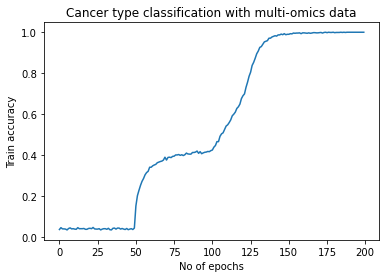

In [34]:
plt.plot(accuracy)
plt.xlabel('No of epochs')
plt.ylabel('Train accuracy')
plt.title('Cancer type classification with multi-omics data')

## Test log

In [13]:
path = "./checkpoints/omics_mode/ABC/ABC_inter2/test_log.txt"
with open(path) as f:
    lines = f.readlines()

In [14]:
l = lines[-2]
spl = l.split(']')[1].split(': ')
int(spl[2].strip().split('  ')[0])
print(l)

[TEST] [Epoch: 200   Iter: 1792]   recon_A: -23.766   recon_B: 0.693   recon_C: -199.021   kl: 2.016   classifier: 0.062   accuracy: 0.971   



In [15]:
def process_test_log(lines):
    recon_A, recon_B, recon_C, kl, classifier, accuracy = [], [], [], [], [], []
    for l in lines:
        if l.startswith("[TEST]"):
            # print(l)
            sp = l.split(']')[2].split(': ')
            spl = l.split(']')[1].split(': ')
            epoch = int(spl[2].strip().split('  ')[0])
            if(epoch==1792):
                recon_A.append(float(sp[1].split('  ')[0]))
                recon_B.append(float(sp[2].split('  ')[0]))
                recon_C.append(float(sp[3].split('  ')[0]))
                kl.append(float(sp[4].split('  ')[0]))
                classifier.append(float(sp[5].split('  ')[0]))
                accuracy.append(float(sp[6].split('  ')[0]))
                # print(recon_A, recon_B, recon_C, kl, classifier, accuracy)
    return recon_A, recon_B, recon_C, kl, classifier, accuracy

In [16]:
recon_A, recon_B, recon_C, kl, classifier, accuracy = process_test_log(lines)

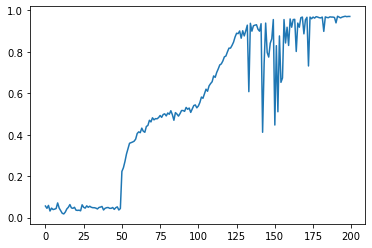

In [17]:
plt.plot(accuracy)